In [55]:
import torch as torch

from src.utils import get_dataset

class args:
    def __init__(self):
        self.num_channels = 1
        self.iid = 1
        self.num_classes = 10
        self.num_users = 10
        self.dataset = 'mnist'

train_dataset, test_dataset, user_groups = get_dataset(args())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
  

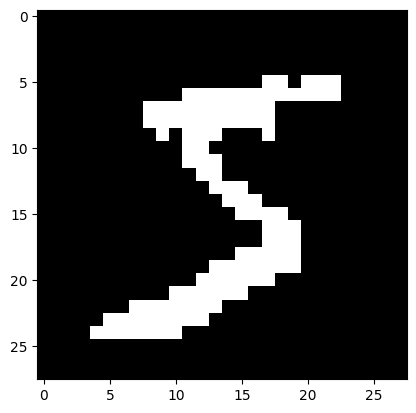

In [2]:
from src.vae.mnist_vae import ConditionalVae
import matplotlib.pyplot as plt
# Train a VAE using normalized MNIST

## Get real data loaded

plt.imshow(train_dataset[0][0][0], cmap='gray')

print(train_dataset[0][0][0])
# Use VAE to generate some data
vae = ConditionalVae(dim_encoding=3).to('cuda:0')

# try with model sigma
vae_model, vae_loss_li, kl_loss_li = vae.train_model(
    training_data=train_dataset,
    batch_size=32,
    epochs=10,
    learning_rate=0.001
)

# Compare generated data with real data

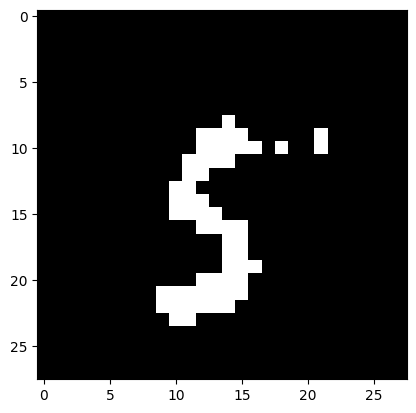

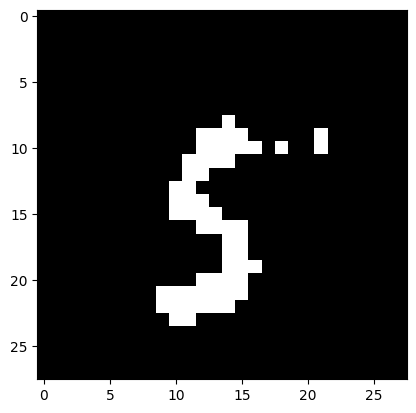

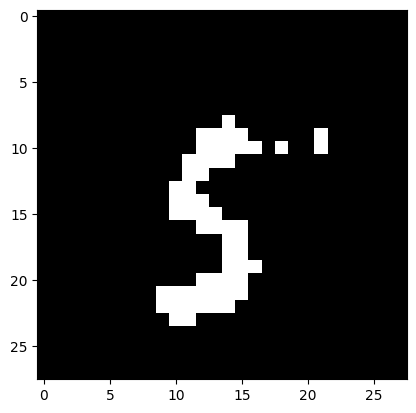

In [12]:
from src.plots import plot_image
from src.impute import impute_cvae_naive

images = impute_cvae_naive(k=1, trained_cvae = vae_model, initial_dataset = torch.tensor([]))
plt.imshow((images[0][0][0]), cmap='gray')
plt.show()
plt.imshow((images[0][0][0]), cmap='gray')
plt.show()
plt.imshow((images[0][0][0]), cmap='gray')
plt.show()
# print(images[0][0].max().item())

In [43]:
print((images[0][0][0]).max().item())
# plt.imshow((images[1][0]*200), cmap='gray')

0.1696428507566452


In [44]:
print(train_dataset[3][0][0].max().item())
# plt.imshow(train_dataset[1][0][0], cmap='gray')


0.14158163964748383


In [44]:
import torch
from src.impute import impute_cvae_naive
# Load cvae that is trained federatedly
vae_model = ConditionalVae(dim_encoding=3)
checkpoint = torch.load("C:\\Users\\lyada\\Desktop\\FederatedImputation\\vae_data\\models\\0_cvae_0.1_cvae.pth")
vae_model.load_state_dict(checkpoint)
gen_dataset = impute_cvae_naive(k=70000, trained_cvae = vae_model, initial_dataset = torch.tensor([]))

In [45]:
import numpy as np
total_len = 0
total_sum = 0
for images, _ in gen_dataset:
    total_sum += images.sum().item()
    total_len += np.prod(images.shape)

mean_value = total_sum/total_len

print("The mean pixel value is:", mean_value)


The mean pixel value is: 0.1612401056851312


In [46]:
import numpy as np
total_len = 0
total_sum = 0
for images, _ in train_dataset:
    total_sum += images.sum().item()
    total_len += np.prod(images.shape)

mean_value = total_sum/total_len

print("The mean pixel value is:", mean_value)


The mean pixel value is: 0.13225831207482994


In [47]:
import pickle

with open('filename_test.pkl', 'wb') as f:
    pickle.dump(gen_dataset, f)


In [71]:
with open('filename.pkl', 'rb') as f:
    loaded_object = pickle.load(f)


1


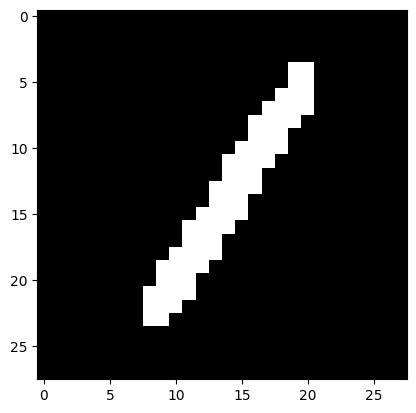

1


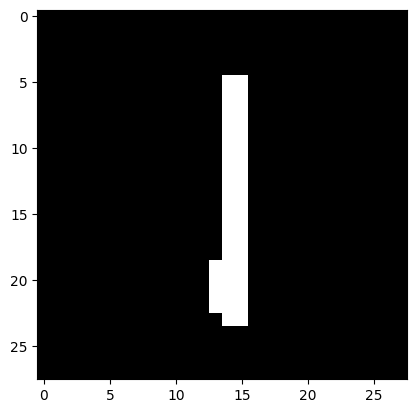

3


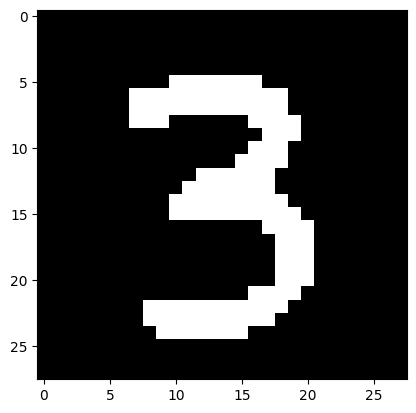

4


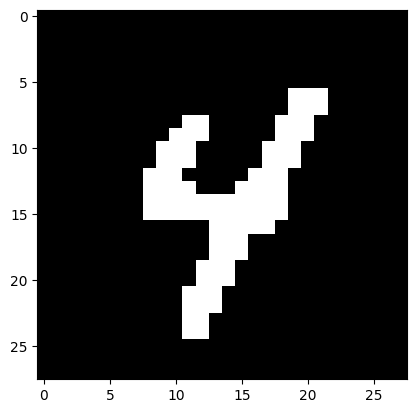

8


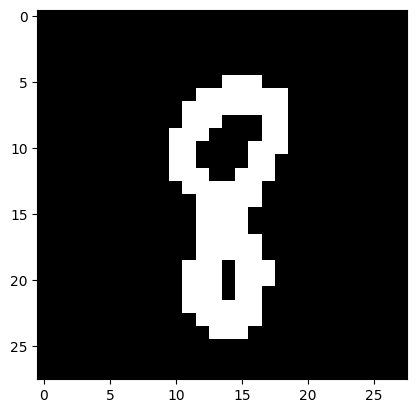

7


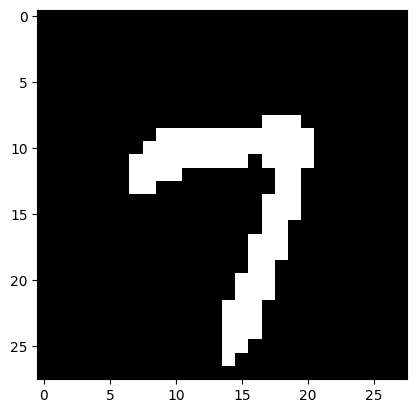

7


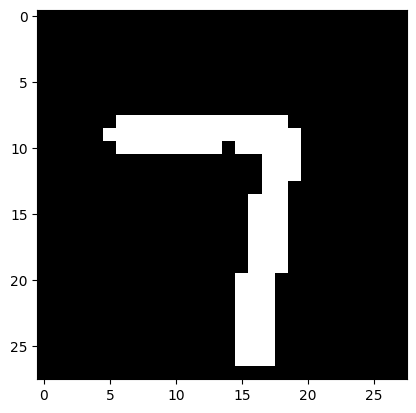

8


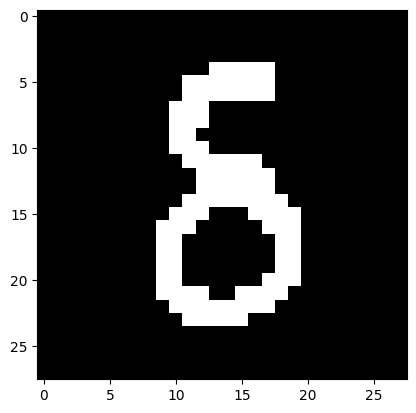

2


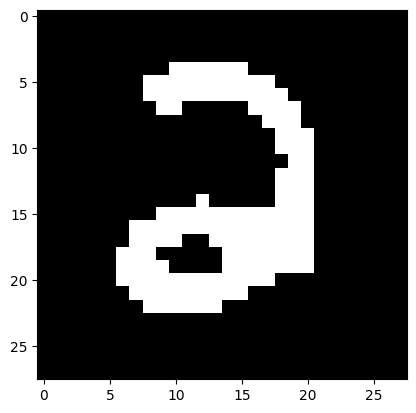

0


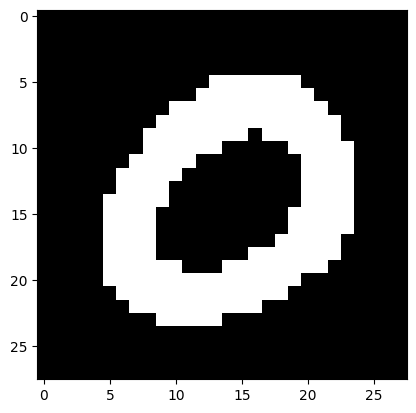

In [72]:
for i in range(10):
    print(loaded_object[i][1])
    plt.imshow(loaded_object[i][0][0], cmap='gray')
    plt.show()

In [73]:
from src.global_model_logic import get_dirch_datalaoders
from tqdm import tqdm
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from torch.version import cuda
from src.models import ExquisiteNetV1
import torch
from torch import nn, optim
device = 'cuda:0'
print(device)

trainloader= DataLoader(loaded_object, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
# Assuming 'model' is your model
model = ExquisiteNetV1(class_num=10, img_channels=1)
model = model.to(device)  # Move model to GPU if available

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs to train the model
n_epochs = 7
train_losses = []
test_losses = []
f1_scores = []
correct_predictions = 0
total_predictions = 0
for epoch in tqdm(range(n_epochs)):
    train_loss = 0.0
    pred_labels = []
    actual_labels = []
    for data, target in trainloader:  # Assuming 'trainloader' is your DataLoader
        data, target = data.to(device), target.to(device)  # Move data to GPU if available

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        pred_labels.append(output.argmax(dim=1))
        actual_labels.append(target)

        # Calculate the loss
        loss = criterion(output, target)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform single optimization step (parameter update)
        optimizer.step()

        # Update running training loss
        train_loss += loss.item() * data.size(0)

    # Switch to evaluation mode
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_pred_labels = []
        test_actual_labels = []
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            test_pred_labels.append(output.argmax(dim=1))
            test_actual_labels.append(target)
             # Compare with actual classes
            total_predictions += output.argmax(dim=1).size(0)
            # correct_predictions += (predicted == labels).sum().item()
            correct_predictions += (output.argmax(dim=1) == target).sum().item()
    # Compute average test loss
    train_loss = train_loss / len(trainloader.dataset)
    test_loss = test_loss / len(testloader.dataset)
    test_losses.append(test_loss)
    train_losses.append(train_loss)
    # Calculate F1 score for the test data
    test_pred_labels = torch.cat(test_pred_labels).to('cpu').numpy()
    test_actual_labels = torch.cat(test_actual_labels).to('cpu').numpy()
    test_f1_score = f1_score(test_actual_labels, test_pred_labels, average='macro')
    f1_scores.append(test_f1_score)
    accuracy = correct_predictions / total_predictions

    print(f'Accuracy: {accuracy * 100}%')
    print('Epoch: {} \tTraining Loss: {:.6f} \t Test Loss: {:.6f} \tF1 Test Macro: {:.6f}'.format(
        epoch + 1,
        train_loss,
        test_loss,
        test_f1_score
    ))

cuda:0


 14%|█▍        | 1/7 [01:47<10:45, 107.58s/it]

Accuracy: 84.68%
Epoch: 1 	Training Loss: 0.110634 	 Test Loss: 0.915021 	F1 Test Macro: 0.843811


 29%|██▊       | 2/7 [03:30<08:45, 105.13s/it]

Accuracy: 83.02000000000001%
Epoch: 2 	Training Loss: 0.054116 	 Test Loss: 1.171877 	F1 Test Macro: 0.808171


 43%|████▎     | 3/7 [05:10<06:51, 102.76s/it]

Accuracy: 83.24000000000001%
Epoch: 3 	Training Loss: 0.032371 	 Test Loss: 1.311746 	F1 Test Macro: 0.834625


 57%|█████▋    | 4/7 [06:53<05:07, 102.52s/it]

Accuracy: 85.085%
Epoch: 4 	Training Loss: 0.023475 	 Test Loss: 0.642411 	F1 Test Macro: 0.905376


 71%|███████▏  | 5/7 [12:23<06:09, 184.85s/it]

Accuracy: 85.65%
Epoch: 5 	Training Loss: 0.021896 	 Test Loss: 0.823088 	F1 Test Macro: 0.877307


 86%|████████▌ | 6/7 [13:06<02:16, 136.59s/it]

Accuracy: 85.82166666666666%
Epoch: 6 	Training Loss: 0.017352 	 Test Loss: 0.854072 	F1 Test Macro: 0.865564


100%|██████████| 7/7 [13:50<00:00, 118.59s/it]

Accuracy: 86.26428571428572%
Epoch: 7 	Training Loss: 0.025908 	 Test Loss: 0.881567 	F1 Test Macro: 0.889076


In [74]:
#This is generated data
# data_loader = torch.utils.data.DataLoader(loaded_object, batch_size=32, shuffle=True)
data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
device = 'cuda:0'

In [75]:
from sklearn.metrics import accuracy_score
import torch

# Assuming that data_loader is the DataLoader for your dataset
correct_predictions = 0
total_predictions = 0
model.eval()

with torch.no_grad():
    for data, labels in data_loader:
        data, labels = data.to(device), labels.to(device)

        # Pass the data to the model
        outputs = model(data)

        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Compare with actual classes
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = correct_predictions / total_predictions

print(f'Accuracy: {accuracy * 100}%')

Accuracy: 88.92%


In [41]:
torch.save(model, "cvae_model_federated.pth")

In [34]:
len(loaded_object)

70000

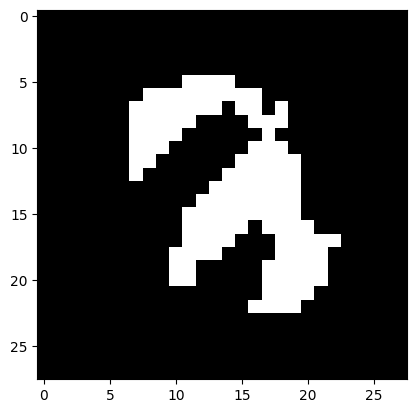

In [67]:
plt.imshow(loaded_object[2][0][0], cmap='gray')
